# Supervised Fine Tuning Qwen3 4B on GSM8K

provided by : Mohammad Taha Majlesi

## installing libraries

In [ ]:
pip install unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.7/182.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.5/155.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0

## Imports and global variables

In [ ]:
import os
import re
import random
import pandas as pd
import torch
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
from trl import SFTTrainer
from sklearn.metrics import accuracy_score, f1_score
from __future__ import annotations
from typing import Callable, List, Dict, Any, Optional, Tuple
from collections import Counter
from huggingface_hub import HfApi


In [ ]:
os.environ["WANDB_DISABLED"] = "true"
torch.manual_seed(3407)

torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")
bf16_ok = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
random.seed(42)
_NUM_RE = re.compile(r"[-+]?\d*\.\d+|\d+")

MODEL_NAME       = "Qwen/Qwen3-4B"
DATASET_NAME = "openai/gsm8k"
SFT_OUTPUT_DIR = "outputs_sft"
ADAPTER_REPO = "tahamajs/Qwen3-4b-gsm8k-Qlora-SFT"
MAX_SEQ_LENGTH = 1024
LORA_RANK = 64
DATASET_CONFIG = "main"
REASONING_TEMPLATE = "<reasoning>\n"
ANSWER_TEMPLATE = "<answer>\n"

DATASET_SPLIT = "test"
BATCH_SIZE = 5
NUM_SAMPLES = 5


SYSTEM_PROMPT = (
    "You are a helpful assistant.\n"
    "First think through the problem, then provide the answer.\n"
    "Use this strict format:\n"
    "<reasoning>\n"
    "your step-by-step reasoning here\n"
    "</reasoning>\n"
    "<answer>\n"
    "The final answer is [final_number].\n"
    "</answer>\n"
)





## Load model and Tokenizer

### load base model

In [ ]:

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float32,
    bnb_4bit_use_double_quant=True,
)


In [ ]:
sft_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,
    device_map="auto"
)
sft_model = prepare_model_for_kbit_training(sft_model)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
lora_config = LoraConfig(
    r=LORA_RANK,
    lora_alpha=LORA_RANK * 2,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
sft_model = get_peft_model(sft_model, lora_config)
sft_model.print_trainable_parameters()

trainable params: 132,120,576 || all params: 4,154,588,672 || trainable%: 3.1801


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

### load model and addapter from huggingface

In [ ]:
base = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    load_in_4bit=True,
)

base = prepare_model_for_kbit_training(base)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
sft_model = PeftModel.from_pretrained(
    base,
    ADAPTER_REPO,
    is_trainable=True,
)

try:
    sft_model.print_trainable_parameters()
except:
    pass

adapter_config.json:   0%|          | 0.00/926 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/529M [00:00<?, ?B/s]

trainable params: 132,120,576 || all params: 4,154,588,672 || trainable%: 3.1801


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

## Helper Functions

In [ ]:


def _extract_last_number(text: Optional[str]) -> str:
    if not text: return ""
    m = _NUM_RE.findall(text)
    return m[-1] if m else ""

def _get_question(ex: Dict[str, Any]) -> str:
    if "question" in ex:
        return ex["question"]
    if "messages" in ex and isinstance(ex["messages"], list) and len(ex["messages"]) >= 2:
        return ex["messages"][1].get("content", "")
    raise KeyError("Example is missing a 'question' or chat-style 'messages' field.")

def _get_reference_answer(ex: Dict[str, Any]) -> str:
    if "answer" in ex and ex["answer"] is not None and ex["answer"] != "":
        return str(ex["answer"])
    if "answer_text" in ex and ex["answer_text"]:
        return _extract_last_number(ex["answer_text"])
    if "solution" in ex:
        return _extract_last_number(ex["solution"])
    return ""

def _detect_model_dtype(model) -> Optional[torch.dtype]:
    dt = getattr(getattr(model, "config", None), "torch_dtype", None)
    if dt is None:
        try:
            dt = model.get_input_embeddings().weight.dtype
        except Exception:
            dt = None
    return dt


def create_prompt(problem_text: str) -> str:
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": problem_text},
    ]
    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )


def evaluate_self_consistency(
    model,
    tokenizer,
    dataset,
    create_prompt: Callable[[str], str],
    num_samples: int = 5,
    batch_size: int = 8,
    max_new_tokens: int = 512,
    temperature: float = 0.7,
    top_p: float = 0.9,
    max_input_len: int = 2048,
    verbose: bool = True,
) -> Dict[str, Any]:
    try:
        tokenizer.padding_side = "right"
    except Exception:
        pass
    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token = tokenizer.eos_token

    if hasattr(dataset, "__len__") and hasattr(dataset, "__getitem__"):
        ds_len = len(dataset)
        get_item = dataset.__getitem__
    else:
        raise TypeError("dataset must be indexable and have __len__ / __getitem__.")

    device = getattr(model, "device", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    model_dtype = _detect_model_dtype(model)

    try:
        model.gradient_checkpointing_disable()
    except Exception:
        pass
    try:
        model.config.use_cache = True
    except Exception:
        pass

    model.eval()

    if verbose:
        print(f"\n--- Starting evaluation with Self-Consistency (samples: {num_samples}) ---")

    predictions: List[str] = []
    references: List[str] = []

    for i in tqdm(range(0, ds_len, batch_size), desc="Evaluating Batches"):
        batch = [get_item(k) for k in range(i, min(i + batch_size, ds_len))]

        batch_questions = [_get_question(ex) for ex in batch]
        batch_prompts   = [create_prompt(q) for q in batch_questions]
        batch_refs      = [_get_reference_answer(ex) for ex in batch]

        enc = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_input_len,
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        with torch.no_grad():
            use_autocast = (device.type == "cuda") and (model_dtype in (torch.float16, torch.bfloat16))
            if use_autocast:
                with torch.autocast(device_type="cuda", dtype=model_dtype):
                    outputs = model.generate(
                        **enc,
                        max_new_tokens=max_new_tokens,
                        do_sample=True,
                        temperature=temperature,
                        top_p=top_p,
                        num_return_sequences=num_samples,
                        pad_token_id=tokenizer.eos_token_id,
                    )
            else:
                outputs = model.generate(
                    **enc,
                    max_new_tokens=max_new_tokens,
                    do_sample=True,
                    temperature=temperature,
                    top_p=top_p,
                    num_return_sequences=num_samples,
                    pad_token_id=tokenizer.eos_token_id,
                )

        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        for j, prompt in enumerate(batch_prompts):
            start = j * num_samples
            end   = start + num_samples
            samples_for_prompt = decoded[start:end]

            sample_answers: List[str] = []
            for text in samples_for_prompt:
                completion_only = text[len(prompt):]
                ans = _extract_last_number(completion_only)
                if ans:
                    sample_answers.append(ans)

            final_answer = ""
            if sample_answers:
                vote_counts = Counter(sample_answers)
                final_answer = vote_counts.most_common(1)[0][0]

            predictions.append(final_answer)
            if verbose:
                print(f"Samples: {sample_answers} -> Voted: {final_answer}, Reference: {batch_refs[j]}")

        references.extend(batch_refs)

    correct = sum(1 for p, r in zip(predictions, references) if (r != "" and p == r))
    total = len(references)
    acc = (correct / total) * 100 if total else 0.0

    if verbose:
        print("\n--- Evaluation Complete ---")
        print(f"Correct Answers: {correct} / {total}")
        print(f"Accuracy: {acc:.2f}%")

    return {
        "accuracy": acc,
        "correct": correct,
        "total": total,
        "predictions": predictions,
        "references": references,
    }


In [ ]:

def extract_hash_answer(text: Optional[str]) -> Optional[str]:
    if not text:
        return None
    m = re.search(r"####\s*([^\n]+)", text)
    return m.group(1).strip().replace(",", "") if m else None


def to_prompt_completion(ex: Dict) -> Dict[str, List[Dict[str, str]]]:
    prompt = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user",   "content": ex["question"]},
    ]
    completion_text = f"<answer>\nThe final answer is {extract_hash_answer(ex['answer'])}.\n</answer>"
    completion = [{"role": "assistant", "content": completion_text}]
    return {"prompt": prompt, "completion": completion}


def get_gsm8k(split: str = "train") -> Dataset:
    ds = load_dataset(DATASET_NAME, DATASET_CONFIG)[split]

    def _map_row(x: Dict) -> Dict:
        final = extract_hash_answer(x.get("answer", None))
        return {
            "messages": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user",   "content": x["question"]},
            ],
            "answer_text": x["answer"],
            "answer": final,
        }

    ds = ds.map(_map_row, remove_columns=[c for c in ds.column_names if c not in {"messages", "answer_text", "answer"}])
    ds = ds.filter(lambda x: x["answer"] is not None and len(x["answer"]) > 0)
    return ds


def build_formatting_func(tokenizer):
    def formatting_func(example: Dict) -> str:
        messages = list(example["messages"])
        response = (
            f"<reasoning>\n{example['answer_text']}\n</reasoning>\n"
            f"<answer>\nThe final answer is {example['answer']}.\n</answer>"
        )
        messages.append({"role": "assistant", "content": response})
        return tokenizer.apply_chat_template(messages, tokenize=False)
    return formatting_func


### Ploting Functions:



In [ ]:

def plot_loss_curves(log_history, title="Training Progress"):
    """Plots training and validation loss curves from Trainer log history."""
    print(f"\nPlotting loss curves for {title}...")
    train_logs = [log for log in log_history if 'loss' in log]
    eval_logs = [log for log in log_history if 'eval_loss' in log]

    plt.figure(figsize=(12, 6))
    if train_logs:
        plt.plot([log['step'] for log in train_logs],
                 [log['loss'] for log in train_logs],
                 label='Training Loss')
    if eval_logs:
        plt.plot([log['step'] for log in eval_logs],
                 [log['eval_loss'] for log in eval_logs],
                 marker='o',
                 label='Validation Loss')

    plt.title(f'Loss Curves - {title}')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_metric(log_history, metric_name, title=None):
    """Plots a single metric over steps."""
    metric_logs = [log for log in log_history if metric_name in log]
    if not metric_logs:
        print(f"No logs found for metric: {metric_name}")
        return

    steps = [log['step'] for log in metric_logs]
    values = [log[metric_name] for log in metric_logs]

    plt.figure(figsize=(12, 6))
    plt.plot(steps, values, marker='o')
    plt.title(title or f'{metric_name} over Steps')
    plt.xlabel('Step')
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.show()


def plot_multiple_metrics(log_history, metric_names, title="Metrics Over Time"):
    """Plots multiple metrics on the same figure."""
    plt.figure(figsize=(12, 6))
    for metric_name in metric_names:
        metric_logs = [log for log in log_history if metric_name in log]
        if not metric_logs:
            print(f"Skipping {metric_name} (not found)")
            continue
        steps = [log['step'] for log in metric_logs]
        values = [log[metric_name] for log in metric_logs]
        plt.plot(steps, values, marker='o', label=metric_name)

    plt.title(title)
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_reward_components(log_history, reward_names=None, every_n=1):
    if reward_names is None:
        keys = set().union(*log_history)
        reward_names = [k for k in keys if k.startswith("reward") or k.startswith("r_")]

    for reward_name in reward_names:
        reward_logs = [log for log in log_history if reward_name in log]
        if not reward_logs:
            print(f"Skipping reward {reward_name} (not found)")
            continue

        steps = [log['step'] for log in reward_logs][::every_n]
        values = [log[reward_name] for log in reward_logs][::every_n]

        plt.figure(figsize=(12, 6))
        plt.plot(steps, values, marker='o', label=reward_name)
        plt.title(f'{reward_name} over Steps')
        plt.xlabel('Step')
        plt.ylabel('Reward')
        plt.grid(True)
        plt.legend()
        plt.show()


## Load Dataset

In [ ]:
full_dataset = get_gsm8k(split="train")

split_dataset = full_dataset.train_test_split(test_size=0.5, seed=42)
train_split = split_dataset['train']
test_split = split_dataset['test']

print(f"Dataset split into {len(train_split)} training and {len(test_split)} testing examples.")

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7473 [00:00<?, ? examples/s]

Dataset split into 3736 training and 3737 testing examples.


## Test Baseline

In [ ]:
samples = random.sample(list(full_dataset), 60)
results = evaluate_self_consistency(
    model=sft_model,
    tokenizer=tokenizer,
    dataset=samples,
    create_prompt=create_prompt,
    num_samples=5,
    batch_size=5,
    max_new_tokens=600,
)
print(f"Final accuracy: {results['accuracy']:.2f}%")

## Data Collector

In [ ]:
class ReasoningAndAnswerCollator:
    def __init__(
        self,
        tokenizer,
        reasoning_template: str = "<reasoning>\n",
        answer_template: str = "<answer>\n",
        pad_to_multiple_of: Optional[int] = None,
        include_template_tokens_in_loss: bool = False,
    ):
        self.tok = tokenizer
        self.reasoning_tmpl = reasoning_template
        self.answer_tmpl = answer_template
        self.reasoning_ids = self.tok.encode(self.reasoning_tmpl, add_special_tokens=False)
        self.answer_ids = self.tok.encode(self.answer_tmpl, add_special_tokens=False)
        self.pad_to_multiple_of = pad_to_multiple_of
        self.include_template_tokens_in_loss = include_template_tokens_in_loss

        if self.tok.pad_token_id is None:
            self.tok.pad_token = self.tok.eos_token

    @staticmethod
    def _find_last_subsequence(seq: List[int], sub: List[int]) -> Optional[int]:
        if not sub or len(sub) > len(seq):
            return None
        last = None
        for i in range(0, len(seq) - len(sub) + 1):
            if seq[i:i+len(sub)] == sub:
                last = i
        return last

    def _compute_start_index(self, input_ids: List[int]) -> Optional[int]:
        start = self._find_last_subsequence(input_ids, self.reasoning_ids)
        tmpl_len = len(self.reasoning_ids)

        if start is None:
            start = self._find_last_subsequence(input_ids, self.answer_ids)
            tmpl_len = len(self.answer_ids)

        if start is None:
            return None

        if not self.include_template_tokens_in_loss:
            start = start + tmpl_len
        return start

    def __call__(self, features: List[Dict]) -> Dict[str, torch.Tensor]:
        for f in features:
            input_ids = f["input_ids"]
            labels = f.get("labels")
            if labels is None:
                labels = list(input_ids)
                f["labels"] = labels

            start = self._compute_start_index(input_ids)
            if start is None:
                for j in range(len(labels)):
                    labels[j] = -100
            else:
                for j in range(0, start):
                    labels[j] = -100

        pad_id = self.tok.pad_token_id
        max_len = max(len(f["input_ids"]) for f in features)
        if self.pad_to_multiple_of:
            rem = max_len % self.pad_to_multiple_of
            if rem != 0:
                max_len += (self.pad_to_multiple_of - rem)

        batch_input_ids, batch_attn, batch_labels = [], [], []
        for f in features:
            ids = f["input_ids"]
            attn = f.get("attention_mask", [1] * len(ids))
            lbl = f["labels"]

            pad_needed = max_len - len(ids)
            if pad_needed > 0:
                ids = ids + [pad_id] * pad_needed
                attn = attn + [0] * pad_needed
                lbl = lbl + [-100] * pad_needed

            batch_input_ids.append(ids)
            batch_attn.append(attn)
            batch_labels.append(lbl)

        return {
            "input_ids": torch.tensor(batch_input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(batch_attn, dtype=torch.long),
            "labels": torch.tensor(batch_labels, dtype=torch.long),
        }

In [ ]:
collator = ReasoningAndAnswerCollator(
    tokenizer,
    reasoning_template=REASONING_TEMPLATE,
    answer_template=ANSWER_TEMPLATE,
    pad_to_multiple_of=8,
    include_template_tokens_in_loss=False
)

formatting_func = build_formatting_func(tokenizer)

### examples

In [ ]:
sample_text = (
    "System: Solve the problem.\n"
    "User: What is 2+2?\n"
    "<reasoning>\nWe add 2 and 2 to get 4.\n</reasoning>\n"
    "<answer>\nThe final answer is 4.\n</answer>"
)
encoded = tokenizer(sample_text, add_special_tokens=False)

features = [{
    "input_ids": encoded["input_ids"],
    "attention_mask": encoded["attention_mask"]
}]

batch = collator(features)

print("=== Decoded full text ===")
print(tokenizer.decode(batch["input_ids"][0], skip_special_tokens=False))

print("\n=== Labels (showing -100 masks) ===")
labels = batch["labels"][0].tolist()
tokens = batch["input_ids"][0].tolist()

for tid, lid in zip(tokens, labels):
    tok_str = tokenizer.decode([tid])
    print(f"{tok_str!r:15} label: {lid}")

print("\nNote: '-100' means this token will be ignored in loss calculation.")

=== Decoded full text ===
System: Solve the problem.
User: What is 2+2?
<reasoning>
We add 2 and 2 to get 4.
</reasoning>
<answer>
The final answer is 4.
</answer>

=== Labels (showing -100 masks) ===
'System'        label: -100
':'             label: -100
' Solve'        label: -100
' the'          label: -100
' problem'      label: -100
'.\n'           label: -100
'User'          label: -100
':'             label: -100
' What'         label: -100
' is'           label: -100
' '             label: -100
'2'             label: -100
'+'             label: -100
'2'             label: -100
'?\n'           label: -100
'<'             label: -100
'reason'        label: -100
'ing'           label: -100
'>\n'           label: -100
'We'            label: 1654
' add'          label: 912
' '             label: 220
'2'             label: 17
' and'          label: 323
' '             label: 220
'2'             label: 17
' to'           label: 311
' get'          label: 633
' '             label: 22

In [ ]:
example = {
    "messages": [
        {"role": "system", "content": "You are a helpful math assistant."},
        {"role": "user",   "content": "What is 2+2?"}
    ],
    "answer_text": "We add 2 and 2 to get 4.",
    "answer": "4"
}

formatted_text = formatting_func(example)
print("=== Formatted text ===")
print(formatted_text)

=== Formatted text ===
<|im_start|>system
You are a helpful math assistant.<|im_end|>
<|im_start|>user
What is 2+2?<|im_end|>
<|im_start|>assistant
<think>

</think>

<reasoning>
We add 2 and 2 to get 4.
</reasoning>
<answer>
The final answer is 4.
</answer><|im_end|>



## Test Base Line

#### Testing with 40 samples


In [ ]:
samples = random.sample(list(full_dataset), 40)
results = evaluate_self_consistency(
    model=sft_model,
    tokenizer=tokenizer,
    dataset=samples,
    create_prompt=create_prompt,
    num_samples=5,
    batch_size=5,
    max_new_tokens=600,
)
print(f"Final accuracy: {results['accuracy']:.2f}%")


--- Starting evaluation with Self-Consistency (samples: 5) ---


Evaluating Batches:  12%|█▎        | 1/8 [05:32<38:50, 332.87s/it]

Samples: ['12', '12.00', '12', '12.00', '12.00'] -> Voted: 12.00, Reference: 12
Samples: ['7', '20', '40', '4', '40'] -> Voted: 40, Reference: 40
Samples: ['160', '160', '160', '160', '160'] -> Voted: 160, Reference: 160
Samples: ['245', '245', '245', '245', '245'] -> Voted: 245, Reference: 245
Samples: ['14', '14', '14', '14', '14'] -> Voted: 14, Reference: 14


Evaluating Batches:  25%|██▌       | 2/8 [11:22<34:15, 342.55s/it]

Samples: ['130', '130', '130', '130', '130'] -> Voted: 130, Reference: 130
Samples: ['3844', '100', '22973.60', '1', '0.8333'] -> Voted: 3844, Reference: 3982
Samples: ['30', '30', '30', '30', '30'] -> Voted: 30, Reference: 30
Samples: ['25', '25', '25', '25', '25'] -> Voted: 25, Reference: 25
Samples: ['150', '61.5', '61.5', '26', '21'] -> Voted: 61.5, Reference: 584


Evaluating Batches:  38%|███▊      | 3/8 [16:37<27:31, 330.32s/it]

Samples: ['2', '1', '30', '9.00', '9.00'] -> Voted: 9.00, Reference: 9
Samples: ['9', '9', '9', '9', '9'] -> Voted: 9, Reference: 9
Samples: ['45', '450', '450', '450', '90'] -> Voted: 450, Reference: 450
Samples: ['7', '7', '7', '7', '7'] -> Voted: 7, Reference: 7
Samples: ['25', '25', '25', '25', '25'] -> Voted: 25, Reference: 25


Evaluating Batches:  50%|█████     | 4/8 [21:52<21:36, 324.24s/it]

Samples: ['260', '200', '260', '26', '260'] -> Voted: 260, Reference: 260
Samples: ['4', '4', '4', '4', '4'] -> Voted: 4, Reference: 4
Samples: ['6', '360', '360', '360', '360'] -> Voted: 360, Reference: 360
Samples: ['100', '100', '100', '100', '100'] -> Voted: 100, Reference: 100
Samples: ['5', '5', '5', '5', '5'] -> Voted: 5, Reference: 5


Evaluating Batches:  62%|██████▎   | 5/8 [27:19<16:15, 325.22s/it]

Samples: ['36', '10', '10', '10', '10'] -> Voted: 10, Reference: 10
Samples: ['4', '4', '4', '4', '4'] -> Voted: 4, Reference: 4
Samples: ['2', '6', '6', '4', '2'] -> Voted: 2, Reference: 16
Samples: ['6', '1', '300', '50', '6'] -> Voted: 6, Reference: 75
Samples: ['96', '2', '8', '2', '4'] -> Voted: 2, Reference: 96


Evaluating Batches:  75%|███████▌  | 6/8 [32:40<10:47, 323.56s/it]

Samples: ['700', '700', '700', '700', '700'] -> Voted: 700, Reference: 700
Samples: ['1', '1', '3', '2', '6'] -> Voted: 1, Reference: 1
Samples: ['24', '24', '24', '24', '24'] -> Voted: 24, Reference: 24
Samples: ['2', '2', '2', '2', '2'] -> Voted: 2, Reference: 2
Samples: ['8', '5', '5', '5', '12'] -> Voted: 5, Reference: 8


Evaluating Batches:  88%|████████▊ | 7/8 [38:04<05:23, 323.86s/it]

Samples: ['270', '150', '50', '150', '405'] -> Voted: 150, Reference: 5950
Samples: ['9', '9', '9', '9', '9'] -> Voted: 9, Reference: 9
Samples: ['65', '65', '20', '65', '20'] -> Voted: 65, Reference: 65
Samples: ['3', '3', '3', '3', '3'] -> Voted: 3, Reference: 3
Samples: ['216', '216', '216', '216', '216'] -> Voted: 216, Reference: 216


Evaluating Batches: 100%|██████████| 8/8 [43:30<00:00, 326.36s/it]

Samples: ['20', '30', '60', '2', '2'] -> Voted: 2, Reference: 1500
Samples: ['4', '2', '40', '4', '6'] -> Voted: 4, Reference: 30
Samples: ['300', '300', '300', '300', '300'] -> Voted: 300, Reference: 300
Samples: ['36', '36', '36', '36', '36'] -> Voted: 36, Reference: 36
Samples: ['10', '10', '10', '10', '10'] -> Voted: 10, Reference: 10

--- Evaluation Complete ---
Correct Answers: 29 / 40
Accuracy: 72.50%
Final accuracy: 72.50%


## Training Arguments

In [ ]:
sft_training_args = TrainingArguments(
    output_dir=SFT_OUTPUT_DIR,
    per_device_train_batch_size=10,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=10,
    learning_rate=9e-4,
    num_train_epochs=2,
    logging_steps=2,
    lr_scheduler_type="cosine",
    eval_strategy="steps",
    eval_steps=2,
    optim="adamw_torch_fused",
    save_strategy="steps",
    save_steps=8,
    bf16=True,
    fp16=False,
    load_best_model_at_end=True,
    report_to="none",
    seed=3407,
)

In [ ]:

subset_indices = random.sample(range(len(test_split)), 20)

eval_subset = test_split.select(subset_indices)
# sft_model = model
sft_trainer = SFTTrainer(
    model=sft_model,
    train_dataset=train_split,
    eval_dataset=eval_subset,
    formatting_func=formatting_func,
    data_collator=collator,
    args=sft_training_args,
)

In [ ]:
sft_trainer.train(resume_from_checkpoint=ADAPTER_REPO)

## Training

### first training



In [ ]:
print("\nStarting SFT training...")
sft_trainer.train()
print("SFT training complete.")


Starting SFT training...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
10,3.958800,3.961658


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


KeyboardInterrupt: 

### second training



In [ ]:
print("\nStarting SFT training...")
sft_trainer.train()
print("SFT training complete.")


Starting SFT training...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
4,No log,3.529874
8,3.773600,3.529874
12,3.773600,3.529874
16,3.781000,3.529874
20,3.781000,3.529874
24,3.774400,3.529874


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant p

KeyboardInterrupt: 

In [ ]:
print("\nStarting SFT training...")
sft_trainer.train()
print("SFT training complete.")


Starting SFT training...


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
2,3.783100,3.896019
4,3.690400,3.896019
6,3.861600,3.896019
8,3.840500,3.896019
10,3.796800,3.896019
12,3.738800,3.896019
14,3.786700,3.896019
16,3.905000,3.896019
18,3.733800,3.896019
20,3.782300,3.896019


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant p

Step,Training Loss,Validation Loss
2,3.783100,3.896019
4,3.690400,3.896019
6,3.861600,3.896019
8,3.840500,3.896019
10,3.796800,3.896019
12,3.738800,3.896019
14,3.786700,3.896019
16,3.905000,3.896019
18,3.733800,3.896019
20,3.782300,3.896019


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant p

KeyboardInterrupt: 

### Save Model

In [ ]:
sft_trainer.save_model(SFT_OUTPUT_DIR)
sft_trainer.save_state()
sft_model.save_pretrained(SFT_OUTPUT_DIR)
tokenizer.save_pretrained(SFT_OUTPUT_DIR)


('outputs_sft/tokenizer_config.json',
 'outputs_sft/special_tokens_map.json',
 'outputs_sft/chat_template.jinja',
 'outputs_sft/vocab.json',
 'outputs_sft/merges.txt',
 'outputs_sft/added_tokens.json',
 'outputs_sft/tokenizer.json')

## plot Loss:


Plotting loss curves for SFT Qwen3-4B GSM8K...


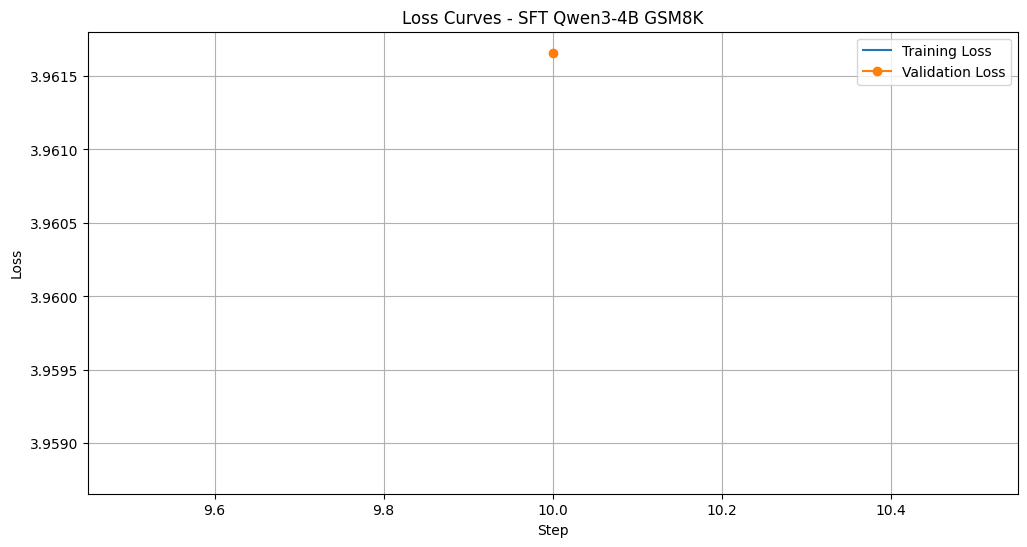

In [ ]:
log_history = sft_trainer.state.log_history

plot_loss_curves(log_history, title="SFT Qwen3-4B GSM8K")
# plot_metric(log_history, 'accuracy', title="Validation Accuracy")
# plot_multiple_metrics(log_history, ['loss', 'eval_loss', 'accuracy'])
plot_reward_components(log_history)


Plotting loss curves for SFT Qwen3-4B GSM8K...


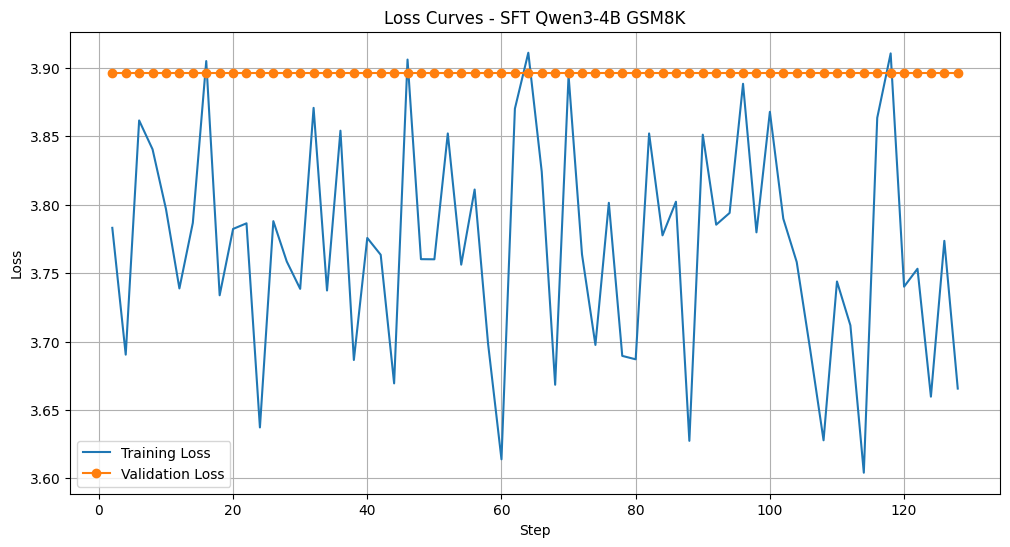

In [ ]:
log_history = sft_trainer.state.log_history

plot_loss_curves(log_history, title="SFT Qwen3-4B GSM8K")
# plot_metric(log_history, 'accuracy', title="Validation Accuracy")
# plot_multiple_metrics(log_history, ['loss', 'eval_loss', 'accuracy'])
plot_reward_components(log_history)

In [ ]:
log_history

[{'loss': 3.9588,
  'grad_norm': 0.0,
  'learning_rate': 0.00018090169943749476,
  'num_tokens': 308681.0,
  'mean_token_accuracy': 0.5561951540410519,
  'epoch': 0.6837606837606838,
  'step': 10},
 {'eval_loss': 3.961658239364624,
  'eval_runtime': 2443.4499,
  'eval_samples_per_second': 1.529,
  'eval_steps_per_second': 0.096,
  'eval_num_tokens': 308681.0,
  'eval_mean_token_accuracy': 0.5563709157654363,
  'epoch': 0.6837606837606838,
  'step': 10}]

### evaluate results:

In [ ]:

gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


#### test random 20 samples

In [ ]:

samples = random.sample(list(full_dataset), 20)
results = evaluate_self_consistency(
    model=sft_model,
    tokenizer=tokenizer,
    dataset=samples,
    create_prompt=create_prompt,
    num_samples=5,
    batch_size=5,
    max_new_tokens=600,
)
print(f"Final accuracy: {results['accuracy']:.2f}%")


--- Starting evaluation with Self-Consistency (samples: 5) ---


Evaluating Batches:  25%|██▌       | 1/4 [05:40<17:02, 340.68s/it]

Samples: ['700', '700', '700', '700', '700'] -> Voted: 700, Reference: 700
Samples: ['14', '14', '14', '14', '14'] -> Voted: 14, Reference: 39
Samples: ['7', '7', '7', '7', '7'] -> Voted: 7, Reference: 7
Samples: ['6', '6', '152', '48', '48'] -> Voted: 6, Reference: 6
Samples: ['4', '4', '4', '4', '4'] -> Voted: 4, Reference: 4


Evaluating Batches:  50%|█████     | 2/4 [10:57<10:53, 326.83s/it]

Samples: ['10', '10', '10', '10', '11'] -> Voted: 10, Reference: 142
Samples: ['130', '130', '130', '130', '130'] -> Voted: 130, Reference: 130
Samples: ['20', '344', '20', '20', '20'] -> Voted: 20, Reference: 20
Samples: ['130', '8', '9', '1', '130'] -> Voted: 130, Reference: 13
Samples: ['570', '570', '570', '570', '570'] -> Voted: 570, Reference: 570


Evaluating Batches:  75%|███████▌  | 3/4 [16:18<05:24, 324.06s/it]

Samples: ['81', '81', '81', '81', '81'] -> Voted: 81, Reference: 81
Samples: ['4096', '4096', '409', '4096', '4096'] -> Voted: 4096, Reference: 4096
Samples: ['7', '7', '7', '7', '7'] -> Voted: 7, Reference: 7
Samples: ['100', '810', '100', '100', '810'] -> Voted: 100, Reference: 810
Samples: ['20', '20', '20', '20', '20'] -> Voted: 20, Reference: 20


Evaluating Batches: 100%|██████████| 4/4 [21:37<00:00, 324.34s/it]

Samples: ['60', '60', '2', '100', '4'] -> Voted: 60, Reference: 60
Samples: ['79', '180', '190', '180', '180'] -> Voted: 180, Reference: 180
Samples: ['19', '19', '19', '19', '19'] -> Voted: 19, Reference: 19
Samples: ['24', '24', '24', '24', '24'] -> Voted: 24, Reference: 24
Samples: ['6', '13', '12', '10', '13'] -> Voted: 13, Reference: 13

--- Evaluation Complete ---
Correct Answers: 16 / 20
Accuracy: 80.00%
Final accuracy: 80.00%


#### test random 40 samples:

In [ ]:
samples = random.sample(list(full_dataset), 40)
results = evaluate_self_consistency(
    model=sft_model,
    tokenizer=tokenizer,
    dataset=samples,
    create_prompt=create_prompt,
    num_samples=5,
    batch_size=8,
    max_new_tokens=600,
)


print(f"Final accuracy: {results['accuracy']:.2f}%")


--- Starting evaluation with Self-Consistency (samples: 5) ---


Evaluating Batches:  10%|█         | 1/10 [05:08<46:19, 308.86s/it]

Samples: ['48', '111', '81', '81', '75'] -> Voted: 81, Reference: 81
Samples: ['50', '960', '1085', '1085', '1085'] -> Voted: 1085, Reference: 1085
Samples: ['9', '5', '5', '5', '9'] -> Voted: 5, Reference: 5
Samples: ['300', '200', '200', '200', '200'] -> Voted: 200, Reference: 200


Evaluating Batches:  20%|██        | 2/10 [10:02<40:00, 300.01s/it]

Samples: ['16', '16', '16', '16', '16'] -> Voted: 16, Reference: 16
Samples: ['5', '5', '5', '5', '5'] -> Voted: 5, Reference: 5
Samples: ['12', '12', '12', '12', '12'] -> Voted: 12, Reference: 12
Samples: ['10', '25', '40', '40', '40'] -> Voted: 40, Reference: 40


Evaluating Batches:  30%|███       | 3/10 [15:08<35:18, 302.61s/it]

Samples: ['600', '600', '600', '120', '600'] -> Voted: 600, Reference: 600
Samples: ['5', '5', '18', '5', '4'] -> Voted: 5, Reference: 5
Samples: ['11', '11', '11', '11', '11'] -> Voted: 11, Reference: 11
Samples: ['500', '10', '286', '50', '5'] -> Voted: 500, Reference: 3214


Evaluating Batches:  40%|████      | 4/10 [19:56<29:40, 296.72s/it]

Samples: ['16', '16', '16', '2', '2'] -> Voted: 16, Reference: 16
Samples: ['5', '180', '180', '180', '180'] -> Voted: 180, Reference: 180
Samples: ['6', '16', '12', '16', '20'] -> Voted: 16, Reference: 16
Samples: ['22', '22', '22', '22', '22'] -> Voted: 22, Reference: 22


Evaluating Batches:  50%|█████     | 5/10 [24:49<24:37, 295.53s/it]

Samples: ['700', '70', '700', '700', '200'] -> Voted: 700, Reference: 700
Samples: ['6240', '6240', '3120', '320', '6240'] -> Voted: 6240, Reference: 6240
Samples: ['404', '404', '404', '404', '404'] -> Voted: 404, Reference: 404
Samples: ['24', '4', '3', '48', '3'] -> Voted: 3, Reference: 3


Evaluating Batches:  60%|██████    | 6/10 [29:34<19:27, 291.87s/it]

Samples: ['2', '2', '2', '10', '2'] -> Voted: 2, Reference: 2
Samples: ['2', '2', '2', '2', '2'] -> Voted: 2, Reference: 2
Samples: ['5', '4.8', '24', '5', '5'] -> Voted: 5, Reference: 184
Samples: ['2', '2', '2', '2', '2'] -> Voted: 2, Reference: 2


Evaluating Batches:  70%|███████   | 7/10 [34:29<14:38, 292.83s/it]

Samples: ['12', '12', '12', '12', '12'] -> Voted: 12, Reference: 12
Samples: ['9', '8', '90', '8', '50'] -> Voted: 8, Reference: 8
Samples: ['150', '150', '2', '150', '150'] -> Voted: 150, Reference: 270
Samples: ['3', '3', '3', '3', '3'] -> Voted: 3, Reference: 3


Evaluating Batches:  80%|████████  | 8/10 [39:19<09:43, 291.93s/it]

Samples: ['12', '12', '2', '16', '2'] -> Voted: 12, Reference: 12
Samples: ['4', '4', '4', '4', '4'] -> Voted: 4, Reference: 4
Samples: ['4', '56', '1', '56', '56'] -> Voted: 56, Reference: 56
Samples: ['22', '118', '12', '118', '24'] -> Voted: 118, Reference: 118


Evaluating Batches:  90%|█████████ | 9/10 [44:10<04:51, 291.76s/it]

Samples: ['23', '21', '21', '21', '12'] -> Voted: 21, Reference: 21
Samples: ['70', '70', '70', '70', '70'] -> Voted: 70, Reference: 70
Samples: ['4', '20', '4', '4', '5'] -> Voted: 4, Reference: 44
Samples: ['48', '48', '48', '48', '48'] -> Voted: 48, Reference: 48


Evaluating Batches: 100%|██████████| 10/10 [49:01<00:00, 294.16s/it]

Samples: ['50', '50', '50', '50', '50'] -> Voted: 50, Reference: 50
Samples: ['75', '2', '2', '75', '2'] -> Voted: 2, Reference: 2
Samples: ['15', '150', '1', '950', '1000'] -> Voted: 15, Reference: 50
Samples: ['53', '18', '105', '105', '3'] -> Voted: 105, Reference: 53

--- Evaluation Complete ---
Correct Answers: 34 / 40
Accuracy: 85.00%
Final accuracy: 85.00%




### Merge model

In [ ]:
merged_sft_model = sft_model.merge_and_unload()

merged_sft_model.save_pretrained(SFT_OUTPUT_DIR)

### push to hub:

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:

from huggingface_hub import HfApi
api = HfApi()


api.create_repo(
    repo_id=ADAPTER_REPO,
    private=False,
    exist_ok=True
)

api.upload_folder(
    folder_path=SFT_OUTPUT_DIR,
    repo_id=ADAPTER_REPO,
    repo_type="model",
    commit_message="add files"
)

It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...puts_sft/checkpoint-24/optimizer.pt: 100%|##########| 1.66kB / 1.66kB            

  ...uts_sft/checkpoint-24/rng_state.pth: 100%|##########| 14.6kB / 14.6kB            

  ...puts_sft/checkpoint-24/scheduler.pt: 100%|##########| 1.47kB / 1.47kB            

  ...tputs_sft/adapter_model.safetensors:   3%|3         | 16.7MB /  529MB            

  ...uts_sft/checkpoint-104/optimizer.pt: 100%|##########| 1.66kB / 1.66kB            

  ...kpoint-24/adapter_model.safetensors:   2%|1         | 8.31MB /  529MB            

  ...ts_sft/checkpoint-24/tokenizer.json:  73%|#######2  | 8.30MB / 11.4MB            

  ...point-104/adapter_model.safetensors:   2%|1         | 8.31MB /  529MB            

  ...ts_sft/checkpoint-104/rng_state.pth: 100%|##########| 14.6kB / 14.6kB            

  ...uts_sft/checkpoint-104/scheduler.pt: 100%|##########| 1.47kB / 1.47kB            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/tahamajs/Qwen3-4b-gsm8k-Qlora-SFT/commit/10434af20d8642a7d4e668901abf9f44ffc4efee', commit_message='add files', commit_description='', oid='10434af20d8642a7d4e668901abf9f44ffc4efee', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tahamajs/Qwen3-4b-gsm8k-Qlora-SFT', endpoint='https://huggingface.co', repo_type='model', repo_id='tahamajs/Qwen3-4b-gsm8k-Qlora-SFT'), pr_revision=None, pr_num=None)